In [1]:
#%pylab inline
import numba, numpy as np, matplotlib.pyplot as plt
from numba import cuda
from pylab import imshow, show
from timeit import default_timer as timer

In [63]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy as np

In [15]:
from lib.model.minimal_model_cuda import *
#get the time_step_kernel
# width,height,chnlno=ic.shape
# kernel_string = get_kernel_string_FK_model(width=width,height=height,DX=0.025, DT=0.1,**kwargs)
# kernel_string = get_kernel_string_FK_model(width=width,height=height,DX=0.025, DT=0.0001,**kwargs)


In [64]:
#make plots in darkmode
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

# (ignore) diffusion kernel with pbc on a 200x200 square grid
keep it simple, stupid!

### pycuda examples, 
- including interactive applets, multiple gpu threads, concurrent kernels, and using thrust
    - https://wiki.tiker.net/PyCuda/Examples
- yet more examples
    - https://github.com/inducer/pycuda/tree/master/examples

### abstract away the complications with pycuda.gpuarray.GPUArray
```
import pycuda.gpuarray as gpuarray
import pycuda.driver as cuda
import pycuda.autoinit
import numpy

a_gpu = gpuarray.to_gpu(numpy.random.randn(4,4).astype(numpy.float32))
a_doubled = (2*a_gpu).get()
print a_doubled
print a_gpu
```

### avoid python overhead with func.prepared_call
```
grid = (1, 1)
block = (4, 4, 1)
func.prepare("P")
func.prepared_call(grid, block, a_gpu)
```

### shortcut for explicit memory copies
The pycuda.driver.In, pycuda.driver.Out, and pycuda.driver.InOut argument handlers can simplify some of the memory transfers. For example, instead of creating a_gpu, if replacing a is fine, the following code can be used:
```
func(cuda.InOut(a), block=(4, 4, 1))
```



In [24]:
mod.get_surfref?
mod.get_texref?

In [21]:
print (a_doubled-2*a)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [19]:
# If there aren’t any errors, the code is now compiled and loaded onto the device. We find a reference to our pycuda.driver.Function and call it, specifying a_gpu as the argument, and a block size of 4x4:
func = mod.get_function("doublify")
func(a_gpu, block=(4,4,1))

a_doubled = numpy.empty_like(a)
cuda.memcpy_dtoh(a_doubled, a_gpu)

In [14]:
#executing a kernel
mod = SourceModule("""
  __global__ void doublify(float *a)
  {
    int idx = threadIdx.x + threadIdx.y*4;
    a[idx] *= 2;
  }
  """)

In [18]:
#transfer data to the gpu

a = np.random.randn(4,4)
#most nvidia gpus only support single point percision.  I think mine does double tho
a = a.astype(np.float32)
a_gpu = cuda.mem_alloc(a.nbytes)
cuda.memcpy_htod(a_gpu, a)


In [9]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule
import numpy as np

# Note that you do not have to use pycuda.autoinit– initialization, context creation, and cleanup can also be performed manually, if desired.

In [2]:
#setup initial conditions
def get_initial_conditions(nx, ny):
    field = np.ones((ny, nx)).astype(np.float32)
    field[np.random.randint(0,nx,size=10), np.random.randint(0,ny,size=10)] = 1e3
    return field

def diffuse(field, dt=0.225):
    field[1:nx-1,1:ny-1] = field[1:nx-1,1:ny-1] + dt * (
        field[1:nx-1,2:ny]+field[2:nx,1:ny-1]-4*field[1:nx-1,1:ny-1]+
        field[0:nx-2,1:ny-1]+field[1:nx-1,0:ny-2] )
    return field

# (numba.cuda) mandelbrot example with numba.cuda


In [3]:
# from numba import autojit
@numba.jit
def mandel(x, y, max_iters):
  """
    Given the real and imaginary parts of a complex number,
    determine if it is a candidate for membership in the Mandelbrot
    set given a fixed number of iterations.
  """
  c = complex(x, y)
  z = 0.0j
  for i in range(max_iters):
    z = z*z + c
    if (z.real*z.real + z.imag*z.imag) >= 4:
      return i

  return max_iters

@numba.jit
def create_fractal(min_x, max_x, min_y, max_y, image, iters):
  height = image.shape[0]
  width = image.shape[1]

  pixel_size_x = (max_x - min_x) / width
  pixel_size_y = (max_y - min_y) / height
    
  for x in range(width):
    real = min_x + x * pixel_size_x
    for y in range(height):
      imag = min_y + y * pixel_size_y
      color = mandel(real, imag, iters)
      image[y, x] = color

In [4]:
from numba import cuda
from numba import *

mandel_gpu = cuda.jit(device=True)(mandel)

Mandelbrot created in 0.317611 s


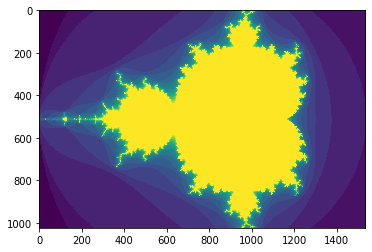

In [5]:
image = np.zeros((1024, 1536), dtype = np.uint8)
start = timer()
create_fractal(-2.0, 1.0, -1.0, 1.0, image, 20) 
dt = timer() - start

print("Mandelbrot created in %f s" % dt)
imshow(image)
show()

In [6]:
@cuda.jit
def mandel_kernel(min_x, max_x, min_y, max_y, image, iters):
  height = image.shape[0]
  width = image.shape[1]

  pixel_size_x = (max_x - min_x) / width
  pixel_size_y = (max_y - min_y) / height

  startX, startY = cuda.grid(2)
  gridX = cuda.gridDim.x * cuda.blockDim.x;
  gridY = cuda.gridDim.y * cuda.blockDim.y;

  for x in range(startX, width, gridX):
    real = min_x + x * pixel_size_x
    for y in range(startY, height, gridY):
      imag = min_y + y * pixel_size_y 
      image[y, x] = mandel_gpu(real, imag, iters)

Mandelbrot created on GPU in 0.004728 s


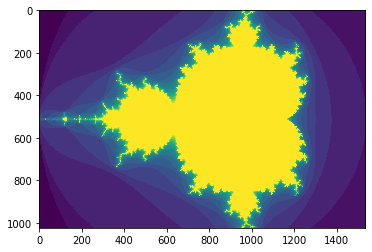

In [8]:
gimage = np.zeros((1024, 1536), dtype = np.uint8)
blockdim = (32, 8)
griddim = (32,16)

start = timer()
d_image = cuda.to_device(gimage)
mandel_kernel[griddim, blockdim](-2.0, 1.0, -1.0, 1.0, d_image, 20) 
d_image.to_host()
dt = timer() - start

print("Mandelbrot created on GPU in %f s" % dt)
imshow(gimage)
show()

## (fail at getting) time_step to be gpu accelerated without alteration

In [ ]:
from lib import *
#load the libraries
from lib.operari import *
from lib.ProgressBar import *
from lib.minimal_model import *
from lib.TexturePlot import *
from lib.get_tips import *
from lib.minimal_model import *
from lib.intersection import *

In [ ]:
from numba import cuda
from numba import *

time_step_gpu = cuda.jit(device=True)(time_step_at_pixel)

In [ ]:
#import the time step and use it on an example texture
file = '/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-2/ic-out/ic_200x200.001.13.npz'
txt = load_buffer(file)
txt.shape

In [ ]:
time_step_cuda(texture=txt, h=0.025, zero_txt=zero_txt.copy())

In [ ]:
zero_txt = np.zeros_like(txt)
for j in range(500):
    time_step(texture=txt, h=0.025, zero_txt=zero_txt.copy())

In [ ]:
time_step_cuda = cuda.jit(device=True)(time_step)

In [ ]:
@cuda.jit
def get_time_step_kernel(texture, out):
    height = texture.shape[0]
    width = texture.shape[1]

    startX, startY = cuda.grid(2)
    gridX = cuda.gridDim.x * cuda.blockDim.x;
    gridY = cuda.gridDim.y * cuda.blockDim.y;

    for x in range(startX, width, gridX):
        for y in range(startY, height, gridY):
            out[y, x] = np.array(time_step_gpu(inVfs=texture,x=x,y=y))

In [ ]:
1024/32
1536/32

In [ ]:
# # gimage = np.zeros((1024, 1536), dtype = np.uint8)
# gimage = np.zeros((1024, 1536, 3), dtype = np.float32)
# # gimage = txt.copy()
# dtexture_dt = gimage.copy()#zero_txt.copy()

# blockdim = (32, 8)
# griddim = (32,16)

# start = timer()
# d_image = cuda.to_device(gimage)
# d_dtexture_dt = cuda.to_device(dtexture_dt)
# get_time_step_kernel[griddim, blockdim](txt, d_dtexture_dt)
# d_image.to_host()
# dt = timer() - start

# print("Mandelbrot created on GPU in %f s" % dt)
# imshow(gimage)
# show()

## (not working) fast matrix multiplication 
but complicated to understand and isn't being called right

In [ ]:
from numba import cuda, float32

# Controls threads per block and shared memory usage.
# The computation will be done on blocks of TPBxTPB elements.
TPB = 16

@cuda.jit
def fast_matmul(A, B, C):
    # Define an array in the shared memory
    # The size and type of the arrays must be known at compile time
    sA = cuda.shared.array(shape=(TPB, TPB), dtype=float32)
    sB = cuda.shared.array(shape=(TPB, TPB), dtype=float32)

    x, y = cuda.grid(2)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bpg = cuda.gridDim.x    # blocks per grid

    if x >= C.shape[0] and y >= C.shape[1]:
        # Quit if (x, y) is outside of valid C boundary
        return

    # Each thread computes one element in the result matrix.
    # The dot product is chunked into dot products of TPB-long vectors.
    tmp = 0.
    for i in range(bpg):
        # Preload data into shared memory
        sA[tx, ty] = A[x, ty + i * TPB]
        sB[tx, ty] = B[tx + i * TPB, y]

        # Wait until all threads finish preloading
        cuda.syncthreads()

        # Computes partial product on the shared memory
        for j in range(TPB):
            tmp += sA[tx, j] * sB[j, ty]

        # Wait until all threads finish computing
        cuda.syncthreads()

    C[x, y] = tmp

In [ ]:
A = np.ones((200,200))
B = 2*A.copy()
C = np.zeros_like(A)

In [ ]:
fast_matmul(A, B, C)
C

In [ ]:
@cuda.jit
def matmul(A, B, C):
    """Perform square matrix multiplication of C = A * B
    """
    i, j = cuda.grid(2)
    if i < C.shape[0] and j < C.shape[1]:
        tmp = 0.
        for k in range(A.shape[1]):
            tmp += A[i, k] * B[k, j]
        C[i, j] = tmp

In [ ]:
matmul(A, B, C)

In [ ]:
C

## (still with numba.cuda) add two matrices the same shape as my texture with float64 percision

In [ ]:
from numba import cuda
# from numba import *

In [ ]:
# from numba import autojit
@numba.jit
def add(a, b):
    return a + b

In [ ]:
foo_gpu = cuda.jit(device=True)(add)

In [ ]:
@cuda.jit
def foo_kernel(image1, image2, out):
    height = image1.shape[0]
    width  = image1.shape[1]

    startX, startY = cuda.grid(2)
    gridX = cuda.gridDim.x * cuda.blockDim.x;
    gridY = cuda.gridDim.y * cuda.blockDim.y;

    for x in range(startX, width, gridX):
        for y in range(startY, height, gridY):
            a = image1[y,x]
            b = image2[y,x]
            out[y, x] = a+b#foo_gpu(a, b)

In [ ]:
gout    = np.zeros((1024, 1536), dtype = np.uint8)
gimage1 = np.ones((1024, 1536), dtype = np.uint8)
gimage2 = np.ones((1024, 1536), dtype = np.uint8)
blockdim = (32, 8)
griddim = (32,16)

start = timer()
d_image1 = cuda.to_device(gimage1)
d_image2 = cuda.to_device(gimage1)
d_out    = cuda.to_device(gout)
foo_kernel[griddim, blockdim](d_image1, d_image2, d_out) 
d_out.to_host()
dt = timer() - start

print("Output created on GPU in %f s" % dt)
imshow(gout)
show()

In [ ]:
gout    = np.zeros((200, 200), dtype = np.float64)
gimage1 = 2*np.ones((200, 200), dtype = np.float64)
gimage2 = np.ones((200, 200), dtype = np.float64)
blockdim = (32, 8)
griddim = (32,16)

start = timer()
d_image1 = cuda.to_device(gimage1)
d_image2 = cuda.to_device(gimage2)
d_out    = cuda.to_device(gout)
foo_kernel[griddim, blockdim](d_image1, d_image2, d_out) 
d_out.to_host()
dt = timer() - start

print("Output created on GPU in %f s" % dt)
imshow(gout)
show()

In [5]:
assert ( (gout==3).all() ) 

NameError: name 'gout' is not defined

# (numba.cuda) compute the diffusion time step with float64 percision with periodic boundary conditions using numba.cuda (it's slow)

In [ ]:
@numba.njit
def _pbc(S,y,x,height,width):
    '''S = numpy array with size (height,width)
    (y, x) pixel coordinates in S, enforcing periodic boundary conditions explicitely.'''
    if ( x < 0  ):# // Left P.B.C.
        x = width - 1
    elif ( x > (width - 1) ):# // Right P.B.C.
        x = 0
    if( y < 0 ):# //  Bottom P.B.C.
        y = height - 1
    elif ( y > (height - 1)):# // Top P.B.C.
        y = 0
    return S[y,x]

In [ ]:
# _pbc(gout,5,201,200,200)

In [ ]:
_pbc_gpu = cuda.jit(device=True)(_pbc)

In [ ]:
#model parameters
diff_coef = 0.0005 #cm^2/ms
h  = 0.025 #ms
dx = 0.025 #cm
cddx = 1/dx**2

@cuda.jit
def diffusion_kernel(Vin, Vout):
    '''writes the simple diffusion term to Vout'''
    height = Vin.shape[0]
    width  = Vin.shape[1]
    
#     #model parameters
#     diff_coef = 0.0005 #cm^2/ms
#     h  = 0.025 #ms
#     dx = 0.025 #cm
#     cddx = 1/dx**2
    
    startX, startY = cuda.grid(2)
    gridX = cuda.gridDim.x * cuda.blockDim.x;
    gridY = cuda.gridDim.y * cuda.blockDim.y;

    for x in range(startX, width, gridX):
        for y in range(startY, height, gridY):
            up     = _pbc_gpu(Vin,y+1,x,height,width)
            down   = _pbc_gpu(Vin,y-1,x,height,width)
            left   = _pbc_gpu(Vin,y,x-1,height,width)
            right  = _pbc_gpu(Vin,y,x+1,height,width)
            center = _pbc_gpu(Vin,y,x,height,width)
            
            #five point stencil
            dVlt2dt = up + down + left + right - 4 * center
            dVlt2dt *= diff_coef * cddx
            Vout[y,x] = center + h*dVlt2dt

In [ ]:
Vout   = np.zeros((200, 200), dtype = np.float64)
Vin  = np.array([256*x*(y+1) for x in range(200) for y in range(200)]).reshape((200,200))
gimage2 = np.ones((200, 200), dtype = np.float64)
blockdim = (32, 8)
griddim = (32,16)

start = timer()
d_Vin = cuda.to_device(Vin)
d_Vout = cuda.to_device(Vout)
diffusion_kernel[griddim, blockdim](d_Vin, d_Vout) 
d_Vout.to_host()
dt = timer() - start

print("Diffusion created on GPU in %f s" % dt)
vmax = Vin.max()
vmin = Vin.min()
imshow(Vin, vmax=vmax,vmin=vmin)
show()

In [ ]:
# now make an n_forward_steps kernel
# @numba.njit
def take_2n_steps_forward_kernel(V1, V2, n):
    for step in range(n):
        diffusion_kernel[griddim, blockdim](V1, V2)
        diffusion_kernel[griddim, blockdim](V2, V1)

In [ ]:
Vout   = np.zeros((200, 200), dtype = np.float64)
Vin  = np.array([256*x*(y+1) for x in range(200) for y in range(200)]).reshape((200,200))
gimage2 = np.ones((200, 200), dtype = np.float64)
blockdim = (32, 8)
griddim = (32,16)

start = timer()
d_Vin = cuda.to_device(Vin)
d_Vout = cuda.to_device(Vout)
take_2n_steps_forward_kernel(d_Vin, d_Vout, 1000) 
d_Vout.to_host()
dt = timer() - start

print("Diffusion created on GPU in %f s" % dt)
vmax = Vin.max()
vmin = Vin.min()
imshow(Vout, vmax=vmax,vmin=vmin)
show()

In [ ]:
# now make an n_forward_steps kernel
# @numba.njit
def take_2n_steps_forward_kernel(V1, V2, n):
    for step in range(n):
        diffusion_kernel[griddim, blockdim, stream](V1, V2)
        diffusion_kernel[griddim, blockdim, stream](V2, V1)

In [ ]:
# # def test_event_elapsed_stream(self):
# N = 32
# stream = cuda.stream()
# dary = cuda.device_array(N, dtype=np.int)
# evtstart = cuda.event()
# evtend = cuda.event()

# evtstart.record(stream=stream)
# cuda.to_device(np.arange(N), to=dary, stream=stream)
# evtend.record(stream=stream)
# evtend.wait(stream=stream)
# evtend.synchronize()
# # Exercise the code path
# take_2n_steps_forward_kernel(d_Vin, d_Vout, 10000) 
# evtstart.elapsed_time(evtend)

In [ ]:
iterations = 10**3
Vout   = np.zeros((200, 200), dtype = np.float64)
Vin   = np.zeros((200, 200), dtype = np.float64)
Vin[0,150] = 1000
# Vin[-1,-1] = 1000
# Vin  = np.array([256*x*(y+1) for x in range(200) for y in range(200)]).reshape((200,200))
gimage2 = np.ones((200, 200), dtype = np.float64)
blockdim = (32, 8)
griddim = (32,16)

start = timer()
stream = cuda.stream()
d_Vin  = cuda.to_device(Vin, stream)
d_Vout = cuda.to_device(Vout, stream)
# take_2n_steps_forward_kernel(d_Vin, d_Vout, iterations) 
for step in range(iterations):
    diffusion_kernel[griddim, blockdim, stream](d_Vin, d_Vout)
    diffusion_kernel[griddim, blockdim, stream](d_Vout, d_Vin)
d_Vout.to_host(stream)
d_Vin.to_host(stream)
stream.synchronize()
dt = timer() - start


print(f"{iterations:d} diffusion time steps taken on GPU in {dt:.3f} seconds!")
vmax = Vin.max()
vmin = Vin.min()
imshow(Vin, vmax=vmax,vmin=vmin)
show()

In [ ]:
# cuda.compiler.AutoTuner(diffusion_kernel, (griddim, blockdim, stream))

In [ ]:
cuda.close()

## (not working/ difficult in numba.cuda)try to use shared memory to speed up the diffusion simulation

In [ ]:
from numba import cuda, float32

# Controls threads per block and shared memory usage.
# The computation will be done on blocks of TPBxTPB elements.
TPB = 10

@cuda.jit
def fast_matmul(A, B, C):
    # Define an array in the shared memory
    # The size and type of the arrays must be known at compile time
    sA = cuda.shared.array(shape=(TPB, TPB), dtype=float64)
    sB = cuda.shared.array(shape=(TPB, TPB), dtype=float64)

    x, y = cuda.grid(2)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bpg = cuda.gridDim.x    # blocks per grid

    if x >= C.shape[0] and y >= C.shape[1]:
        # Quit if (x, y) is outside of valid C boundary
        return

    # Each thread computes one element in the result matrix.
    # The dot product is chunked into dot products of TPB-long vectors.
    tmp = 0.
    for i in range(bpg):
        # Preload data into shared memory
        sA[tx, ty] = A[x, ty + i * TPB]
        sB[tx, ty] = B[tx + i * TPB, y]

        # Wait until all threads finish preloading
        cuda.syncthreads()

        # Computes partial product on the shared memory
        for j in range(TPB):
            tmp += sA[tx, j] * sB[j, ty]

        # Wait until all threads finish computing
        cuda.syncthreads()

    C[x, y] = tmp

In [ ]:
#model parameters
diff_coef = 0.0005 #cm^2/ms
h  = 0.025 #ms
dx = 0.025 #cm
cddx = 1/dx**2

@cuda.jit
def diffusion_kernel(Vin, Vout):
    '''writes the simple diffusion term to Vout'''
    height = Vin.shape[0]
    width  = Vin.shape[1]
    
    # Define an array in the shared memory
    # The size and type of the arrays must be known at compile time
    sA = cuda.shared.array(shape=(TPB, TPB), dtype=float64)
    sB = cuda.shared.array(shape=(TPB, TPB), dtype=float64
#     #model parameters
#     diff_coef = 0.0005 #cm^2/ms
#     h  = 0.025 #ms
#     dx = 0.025 #cm
#     cddx = 1/dx**2
    
    startX, startY = cuda.grid(2)
    gridX = cuda.gridDim.x * cuda.blockDim.x;
    gridY = cuda.gridDim.y * cuda.blockDim.y;

    for x in range(startX, width, gridX):
        for y in range(startY, height, gridY):
            up     = _pbc_gpu(Vin,y+1,x,height,width)
            down   = _pbc_gpu(Vin,y-1,x,height,width)
            left   = _pbc_gpu(Vin,y,x-1,height,width)
            right  = _pbc_gpu(Vin,y,x+1,height,width)
            center = _pbc_gpu(Vin,y,x,height,width)
            
            #five point stencil
            dVlt2dt = up + down + left + right - 4 * center
            dVlt2dt *= diff_coef * cddx
            Vout[y,x] = center + h*dVlt2dt

In [ ]:
# # now make an n_forward_steps kernel
# # @numba.njit
# def take_2n_steps_forward_kernel(V1, V2, n):
#     for step in range(n):
#         diffusion_kernel[griddim, blockdim, stream](V1, V2)
#         diffusion_kernel[griddim, blockdim, stream](V2, V1)

cuda.gpus[0]

In [ ]:
import numba.cuda

@numba.cuda.jit
def smooth_gpu(x, out):
    i, j = cuda.grid(2)
    n, m = x.shape
    if 1 <= i < n - 1 and 1 <= j < m - 1:
        out[i, j] = (x[i - 1, j - 1] + x[i - 1, j] + x[i - 1, j + 1] +
                     x[i    , j - 1] + x[i    , j] + x[i    , j + 1] +
                     x[i + 1, j - 1] + x[i + 1, j] + x[i + 1, j + 1]) // 9

import cupy, math

x_gpu = cupy.ones((10000, 10000), dtype='int8')
out_gpu = cupy.zeros((10000, 10000), dtype='int8')

# I copied the four lines below from the Numba docs
threadsperblock = (16, 16)
blockspergrid_x = math.ceil(x_gpu.shape[0] / threadsperblock[0])
blockspergrid_y = math.ceil(x_gpu.shape[1] / threadsperblock[1])
blockspergrid = (blockspergrid_x, blockspergrid_y)

smooth_gpu[blockspergrid, threadsperblock](x_gpu, out_gpu)

# dev pycuda

- DONE: finish installation at https://docs.nvidia.com/cuda/cuda-quick-start-guide/index.html#ubuntu-x86_64-deb
- DONE: then finish following along with pycuda howdo https://benvanwerkhoven.github.io/kernel_tuner/diffusion.html
- TODO: then include a local term for I_ion_gpu(V,f,s)
- TODO: test the simulation out, visualize it.  Does it look reasonable?
- TODO: tune the simulation for faster runtime using ^that howdo
- TODO: include an optional stimulus field for 2ms for a given stimulus field (constant)
- TODO: have nsteps_back, nsteps_forward, and consider using implicit midpoint rule.

In [ ]:
# !pip install pycuda

In [26]:
#do the imports we need
import numpy as np
from matplotlib import pyplot
%matplotlib inline

from pylab import imshow, show
from timeit import default_timer as timer

import pycuda

KeyboardInterrupt: 

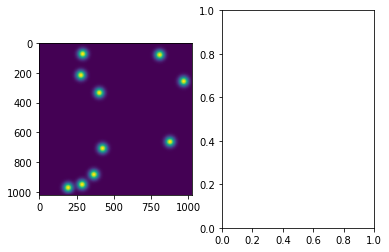

In [13]:
def diffuse(field, dt=0.225):
    field[1:nx-1,1:ny-1] = field[1:nx-1,1:ny-1] + dt * (
        field[1:nx-1,2:ny]+field[2:nx,1:ny-1]-4*field[1:nx-1,1:ny-1]+
        field[0:nx-2,1:ny-1]+field[1:nx-1,0:ny-2] )
    return field

nx = 1024
ny = 1024

#setup initial conditions
def get_initial_conditions(nx, ny):
    field = np.ones((ny, nx)).astype(np.float32)
    field[np.random.randint(0,nx,size=10), np.random.randint(0,ny,size=10)] = 1e3
    return field
field = get_initial_conditions(nx, ny)

#run the diffuse function a 1000 times and another 2000 times and make plots
fig, (ax1, ax2) = pyplot.subplots(1,2)
for i in range(1000):
    field = diffuse(field)
ax1.imshow(field)
for i in range(2000):
    field = diffuse(field)
ax2.imshow(field)

In [ ]:
#save the current field for later use
field_copy = np.copy(field)
iterations = 10**4

#run another 1000 steps of the diffuse function and measure the time
from time import time
start = time()
for i in range(2*iterations):
    field = diffuse(field)
end = time()
print(f"{iterations*2} steps of diffuse took", (end-start)*1000.0, "ms")
pyplot.imshow(field)

In [ ]:
def get_kernel_string(nx, ny):
    return """
    #define nx %d
    #define ny %d
    #define dt 0.225f
    __global__ void diffuse_kernel(float *u_new, float *u) {
        int x = blockIdx.x * block_size_x + threadIdx.x;
        int y = blockIdx.y * block_size_y + threadIdx.y;

        if (x>0 && x<nx-1 && y>0 && y<ny-1) {
            u_new[y*nx+x] = u[y*nx+x] + dt * (
                u[(y+1)*nx+x]+u[y*nx+x+1]-4.0f*u[y*nx+x]+u[y*nx+x-1]+u[(y-1)*nx+x]);
        }
    }
    """ % (nx, ny)
kernel_string = get_kernel_string(nx, ny)

In [25]:
#do the imports we need
import numpy as np
from matplotlib import pyplot
%matplotlib inline

from pylab import imshow, show
from timeit import default_timer as timer

import pycuda

import pycuda.driver as drv
from pycuda.compiler import SourceModule



In [ ]:
#initialize PyCuda and get compute capability needed for compilation
drv.init()
context = drv.Device(0).make_context()
devprops = { str(k): v for (k, v) in context.get_device().get_attributes().items() }
cc = str(devprops['COMPUTE_CAPABILITY_MAJOR']) + str(devprops['COMPUTE_CAPABILITY_MINOR'])



#allocate GPU memory
u_old = drv.mem_alloc(field_copy.nbytes)
u_new = drv.mem_alloc(field_copy.nbytes)



#setup thread block dimensions and compile the kernel
threads = (16,16,1)
grid = (int(nx/16), int(ny/16), 1)
block_size_string = "#define block_size_x 16\n#define block_size_y 16\n"

#CRASH: the following line will not run because my gcc compiler is too new for pycuda...
# diffuse_kernel = SourceModule(block_size_string+kernel_string,
#                               arch='sm_'+cc).get_function("diffuse_kernel")

diffuse_kernel = SourceModule(block_size_string+kernel_string).get_function("diffuse_kernel")


#create events for measuring performance
start = drv.Event()
end = drv.Event()

In [ ]:
#move the data to the GPU
drv.memcpy_htod(u_old, field_copy)
drv.memcpy_htod(u_new, field_copy)
# iterations = 10**4
#call the GPU kernel a 1000 times and measure performance
context.synchronize()
start.record()
for i in range(iterations):
    diffuse_kernel(u_new, u_old, block=threads, grid=grid)
    diffuse_kernel(u_old, u_new, block=threads, grid=grid)
end.record()
context.synchronize()
print(f"{iterations*2} steps of diffuse took", end.time_since(start), "ms.")

#copy the result from the GPU to Python for plotting
gpu_result = numpy.zeros_like(field_copy)
drv.memcpy_dtoh(gpu_result, u_new)
fig, (ax1, ax2) = pyplot.subplots(1,2)
ax1.imshow(gpu_result)
ax1.set_title("GPU Result")
ax2.imshow(field)
ax2.set_title("Python Result")

# pycuda kernel autotuning is suprisingly easy

In [28]:
nx = 4096
ny = 4096
field = get_initial_conditions(nx, ny)
# kernel_string = get_kernel_string(nx, ny)
# kernel_string = get_kernel_string(nx, ny, D = 0.0005, dt = 0.025, dx = 0.025)
kernel_string = get_kernel_string_FK_model( DX=0.025,DT=0.025,width=width,height=height,**kwargs)


NameError: name 'width' is not defined

In [24]:
from collections import OrderedDict
tune_params = OrderedDict()
tune_params["block_size_x"] = [16, 32, 48, 64, 128]
tune_params["block_size_y"] = [2, 4, 8, 16, 32,64,128]

In [19]:
args = [field, field]


In [20]:
problem_size = (nx, ny)

In [21]:
from kernel_tuner import tune_kernel
result = tune_kernel("diffuse_kernel", kernel_string, problem_size, args, tune_params)

NameError: name 'kernel_string' is not defined

best performing configuration: block_size_x=16, block_size_y=32, time=1.1265325716563634ms


In [47]:
# !pip install kernel_tuner
np.log2(4096)


12.0

# diffusion with pbc on a pycuda kernel
- TODO: get the sim working on a 200x200 grid.
        - NB: note that width does not need to equal nx...
- TODO: get the sim working with my own defined initial conditions

In [19]:
#do the imports we need
import numpy as np
from matplotlib import pyplot
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import imshow, show
from timeit import default_timer as timer

import pycuda

import pycuda.driver as drv
from pycuda.compiler import SourceModule

#run this once.  if you run in ~30 times, you will get the following error
# MemoryError: cuCtxCreate failed: out of memory 
#initialize PyCuda and get compute capability needed for compilation
drv.init()
context = drv.Device(0).make_context()
devprops = { str(k): v for (k, v) in context.get_device().get_attributes().items() }
cc = str(devprops['COMPUTE_CAPABILITY_MAJOR']) + str(devprops['COMPUTE_CAPABILITY_MINOR'])


In [24]:
nx = 1024#200#1024
ny = 1024#200#1024
threads = (16,16,1)
grid = (int(nx/16), int(ny/16), 1)
block_size_string = "#define block_size_x 16\n#define block_size_y 16\n"


# #save the ic field for later use
# Vin  = np.array([256*x*(y+1) for x in range(nx) for y in range(ny)]).reshape((nx,ny))
# field = Vin.copy()
ic = get_initial_conditions(nx, ny)
field = ic.copy()

field_copy = field.copy()
for q in range(100):
    field_copy = diffuse(field_copy)

In [36]:
def get_kernel_string(nx, ny, D, dt, dx):
    return f"""
#define nx {int(nx)}
#define ny {int(ny)}
#define width nx
#define height ny
#define dcoef {float(D*dt/dx**2)}

// periodic boundary conditions
__device__ int _pbc ( int q, int wid ) {{
    if (q >= wid) {{
        q = 1;
    }}
    if (q <= 0) {{
        q = wid-1;
    }}
     return q;
}}

// main kernel/face shader
__global__ void diffuse_kernel(float *u_new, float *u) {{
    int x = blockIdx.x * block_size_x + threadIdx.x;
    int y = blockIdx.y * block_size_y + threadIdx.y;
    if (x>=0 && x<nx && y>=0 && y<ny) {{
            int up    = _pbc(y+1,height);
            int down  = _pbc(y-1,height);
            int left  = _pbc(x-1, width);
            int right = _pbc(x+1, width);
            
            u_new[y*nx+x] = u[y*nx+x] + dcoef * (
            u[(up)*nx+x]+u[y*nx+right]
            -4.0f*u[y*nx+x]
            +u[y*nx+left]+u[(down)*nx+x]
            );
    }}
}}
    """   
#TODO: unallocate device memory
#     free(a_h); free(b_h); cudaFree(a_d); cudaFree(b_d)

200000 steps of diffuse took 7700 ms.


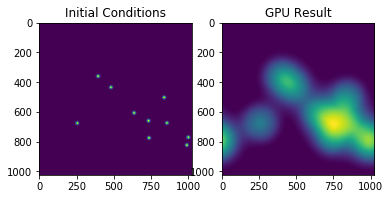

In [39]:
kernel_string = get_kernel_string(nx, ny, D = 0.0005, dt = 0.025, dx = 0.025)
# kernel_string = get_kernel_string(nx, ny)

field = ic.copy()

iterations = 10**4

#allocate GPU memory
u_old = drv.mem_alloc(field_copy.nbytes)
u_new = drv.mem_alloc(field_copy.nbytes)
#setup thread block dimensions and compile the kernel
diffuse_kernel = SourceModule(block_size_string+kernel_string).get_function("diffuse_kernel")
#create events for measuring performance
start = drv.Event()
end = drv.Event()
#move the data to the GPU
drv.memcpy_htod(u_old, field_copy)
drv.memcpy_htod(u_new, field_copy)
#call the GPU kernel a 1000 times and measure performance
context.synchronize()
start.record()
for i in range(iterations):
    diffuse_kernel(u_new, u_old, block=threads, grid=grid)
    diffuse_kernel(u_old, u_new, block=threads, grid=grid)
end.record()
context.synchronize()
print(f"{iterations*2} steps of diffuse took {end.time_since(start):.0f} ms.")

#copy the result from the GPU to Python for plotting
gpu_result = np.zeros_like(field_copy)
drv.memcpy_dtoh(gpu_result, u_new)
fig, (ax1, ax2) = pyplot.subplots(1,2)

ax1.imshow(field_copy)
ax1.set_title("Initial Conditions")
ax2.imshow(gpu_result)
ax2.set_title("GPU Result")
plt.show()

In [6]:
1024/16

64.0

In [35]:
200000*0.025
print('5 seconds of simulation time simulated in 7.7 seconds of real time!')

5 seconds of simulation time simulated in 7.7 seconds of real time!


# diffusion with pbc on a pycuda kernel
- TODO: get the sim working on a 200x200 grid.
        - NB: note that width does not need to equal nx...
- TODO: get the sim working with my own defined initial conditions

In [10]:
#do the imports we need
import numpy as np
from matplotlib import pyplot
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import imshow, show
from timeit import default_timer as timer
import pycuda
# pycuda.autoinit
import pycuda.driver as drv
from pycuda.compiler import SourceModule

#run drv.Device(0).make_context() only once.  if you run in ~30 times, you will get the following error
# MemoryError: cuCtxCreate failed: out of memory 
#initialize PyCuda and get compute capability needed for compilation
drv.init()
context = drv.Device(0).make_context()
devprops = { str(k): v for (k, v) in context.get_device().get_attributes().items() }
cc = str(devprops['COMPUTE_CAPABILITY_MAJOR']) + str(devprops['COMPUTE_CAPABILITY_MINOR'])


Error: cuInit failed: unknown error

In [20]:
#setup initial conditions
def get_initial_conditions(nx, ny):
    field = np.ones((ny, nx)).astype(np.float32)
    field[np.random.randint(0,nx,size=10), np.random.randint(0,ny,size=10)] = 1e3
    return field

def diffuse(field, dt=0.225):
    field[1:nx-1,1:ny-1] = field[1:nx-1,1:ny-1] + dt * (
        field[1:nx-1,2:ny]+field[2:nx,1:ny-1]-4*field[1:nx-1,1:ny-1]+
        field[0:nx-2,1:ny-1]+field[1:nx-1,0:ny-2] )
    return field

In [24]:
nx = 1024#200#1024
ny = 1024#200#1024
threads = (16,16,1)
grid = (int(nx/16), int(ny/16), 1)
block_size_string = "#define block_size_x 16\n#define block_size_y 16\n"


# #save the ic field for later use
# Vin  = np.array([256*x*(y+1) for x in range(nx) for y in range(ny)]).reshape((nx,ny))
# field = Vin.copy()
ic = get_initial_conditions(nx, ny)
field = ic.copy()

field_copy = field.copy()
for q in range(100):
    field_copy = diffuse(field_copy)

In [36]:
def get_kernel_string(nx, ny, D, dt, dx):
    return f"""
#define nx {int(nx)}
#define ny {int(ny)}
#define width nx
#define height ny
#define dcoef {float(D*dt/dx**2)}

// periodic boundary conditions
__device__ int _pbc ( int q, int wid ) {{
    if (q >= wid) {{
        q = 1;
    }}
    if (q <= 0) {{
        q = wid-1;
    }}
     return q;
}}

// main kernel/face shader
__global__ void diffuse_kernel(float *u_new, float *u) {{
    int x = blockIdx.x * block_size_x + threadIdx.x;
    int y = blockIdx.y * block_size_y + threadIdx.y;
    if (x>=0 && x<nx && y>=0 && y<ny) {{
            int up    = _pbc(y+1,height);
            int down  = _pbc(y-1,height);
            int left  = _pbc(x-1, width);
            int right = _pbc(x+1, width);
            
            u_new[y*nx+x] = u[y*nx+x] + dcoef * (
            u[(up)*nx+x]+u[y*nx+right]
            -4.0f*u[y*nx+x]
            +u[y*nx+left]+u[(down)*nx+x]
            );
    }}
}}
    """   
#TODO: unallocate device memory
#     free(a_h); free(b_h); cudaFree(a_d); cudaFree(b_d)

200000 steps of diffuse took 7700 ms.


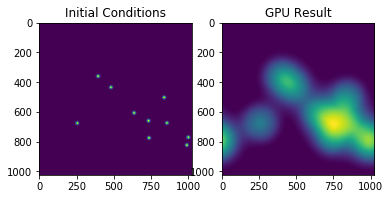

In [39]:
kernel_string = get_kernel_string(nx, ny, D = 0.0005, dt = 0.025, dx = 0.025)
# kernel_string = get_kernel_string(nx, ny)

field = ic.copy()

iterations = 10**4

#allocate GPU memory
u_old = drv.mem_alloc(field_copy.nbytes)
u_new = drv.mem_alloc(field_copy.nbytes)
#setup thread block dimensions and compile the kernel
diffuse_kernel = SourceModule(block_size_string+kernel_string).get_function("diffuse_kernel")
#create events for measuring performance
start = drv.Event()
end = drv.Event()
#move the data to the GPU
drv.memcpy_htod(u_old, field_copy)
drv.memcpy_htod(u_new, field_copy)
#call the GPU kernel a 1000 times and measure performance
context.synchronize()
start.record()
for i in range(iterations):
    diffuse_kernel(u_new, u_old, block=threads, grid=grid)
    diffuse_kernel(u_old, u_new, block=threads, grid=grid)
end.record()
context.synchronize()
print(f"{iterations*2} steps of diffuse took {end.time_since(start):.0f} ms.")

#copy the result from the GPU to Python for plotting
gpu_result = np.zeros_like(field_copy)
drv.memcpy_dtoh(gpu_result, u_new)
fig, (ax1, ax2) = pyplot.subplots(1,2)

ax1.imshow(field_copy)
ax1.set_title("Initial Conditions")
ax2.imshow(gpu_result)
ax2.set_title("GPU Result")
plt.show()

In [6]:
1024/16

64.0

In [35]:
200000*0.025
print('5 seconds of simulation time simulated in 7.7 seconds of real time!')

5 seconds of simulation time simulated in 7.7 seconds of real time!


# more pycuda tutorials


## use pycuda.autoinit to automate things like cleanup
https://documen.tician.de/pycuda/tutorial.html

# diffusion with pbc on a pycuda kernel with custom input
- DONE: run this using pycuda.autoinit
    - does it run as fast? YES
- DONE: get the sim working on a 200x200 grid.
- DONE: get the sim working with my own defined initial conditions

In [1]:
#do the imports we need
import numpy as np
# from matplotlib import pyplot

# %matplotlib inline
import matplotlib.pyplot as plt
# from pylab import imshow, show
from timeit import default_timer as timer

import pycuda
import pycuda.driver as drv
import pycuda.autoinit
from pycuda.compiler import SourceModule




In [2]:
#the following might be needed for the kernel_autotuner.  I think pycuda.autoinit is more idiot-proof.
#run this once.  if you run in ~30 times, you will get the following error
# MemoryError: cuCtxCreate failed: out of memory 
#initialize PyCuda and get compute capability needed for compilation
# drv.init()
context = drv.Device(0).make_context()
devprops = { str(k): v for (k, v) in context.get_device().get_attributes().items() }
cc = str(devprops['COMPUTE_CAPABILITY_MAJOR']) + str(devprops['COMPUTE_CAPABILITY_MINOR'])


In [3]:
#setup initial conditions
def get_initial_conditions(nx, ny):
    field = np.ones((ny, nx)).astype(np.float32)
    field[np.random.randint(0,nx,size=10), np.random.randint(0,ny,size=10)] = 1e3
    return field

def diffuse(field, dt=0.225):
    field[1:nx-1,1:ny-1] = field[1:nx-1,1:ny-1] + dt * (
        field[1:nx-1,2:ny]+field[2:nx,1:ny-1]-4*field[1:nx-1,1:ny-1]+
        field[0:nx-2,1:ny-1]+field[1:nx-1,0:ny-2] )
    return field

In [12]:
grid

(102, 102, 1)

In [14]:
nx = 200#1024#200#1024
ny = 200#1024#200#1024
width  = 200#1024#200
height = 200#1024#200
threads = (10,10,1)
grid = (int(nx/10), int(ny/10), 1)
block_size_string = "#define block_size_x 10\n#define block_size_y 10\n"


# nx = 1024#200#1024
# ny = 1024#200#1024
# width  = 1024#200
# height = 1024#200
# threads = (16,16,1)
# grid = (int(nx/16), int(ny/16), 1)
# block_size_string = "#define block_size_x 16\n#define block_size_y 16\n"


#save the ic field for later use
Vin  = np.array([256*x*(y+1) for x in range(nx) for y in range(ny)]).reshape((nx,ny))
field = Vin.copy()
# ic = get_initial_conditions(nx, ny)
# ic = get_initial_conditions(nx, ny)
# field = ic.copy()

# field_copy = field.copy()
# for q in range(100):
#     field_copy = diffuse(field_copy)
    
# field = field[:height,:width].copy()
# field_copy = field_copy[:height,:width].copy()
print(field.shape)

(200, 200)


In [15]:
def get_kernel_string(nx, ny, D, dt, dx):#width, height):
    return f"""
#define nx {int(nx)}
#define ny {int(ny)}
#define width nx
#define height ny
#define dcoef {float(D*dt/dx**2)}

// periodic boundary conditions
__device__ int _pbc ( int q, int wid ) {{
    if (q >= wid) {{
        q = 1;
    }}
    if (q <= 0) {{
        q = wid-1;
    }}
     return q;
}}

// main kernel/face shader
__global__ void diffuse_kernel(float *u_new, float *u) {{
    int x = blockIdx.x * block_size_x + threadIdx.x;
    int y = blockIdx.y * block_size_y + threadIdx.y;
    if (x>=0 && x<nx && y>=0 && y<ny) {{
            int up    = _pbc(y+1,height);
            int down  = _pbc(y-1,height);
            int left  = _pbc(x-1, width);
            int right = _pbc(x+1, width);
            
            u_new[y*nx+x] = u[y*nx+x] + dcoef * (
            u[(up)*nx+x]+u[y*nx+right]
            -4.0f*u[y*nx+x]
            +u[y*nx+left]+u[(down)*nx+x]
            );
    }}
}}
    """   

In [16]:
#don't allocate memory many times for the same task!

#allocate GPU memory
u_old = drv.mem_alloc(field_copy.nbytes)
u_new = drv.mem_alloc(field_copy.nbytes)

200000 steps of diffuse took 3418 ms.


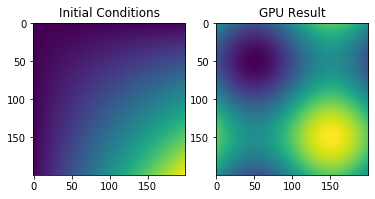

In [28]:
kernel_string = get_kernel_string(nx=width, ny=height, D = 0.0005, dt = 0.025, dx = 0.025)#, width=width, height=height)
# kernel_string = get_kernel_string(nx, ny)

field_copy = Vin.copy().astype(np.float32)#ic.copy()

iterations = 10**5

#setup thread block dimensions and compile the kernel
mod = SourceModule(block_size_string+kernel_string)
diffuse_kernel = mod.get_function("diffuse_kernel")

#create events for measuring performance
start = drv.Event()
end = drv.Event()
#move the data to the GPU
drv.memcpy_htod(u_old, field_copy)
drv.memcpy_htod(u_new, field_copy)
#call the GPU kernel a 1000 times and measure performance
context.synchronize()
start.record()
for i in range(iterations):
    diffuse_kernel(u_new, u_old, block=threads, grid=grid)
    diffuse_kernel(u_old, u_new, block=threads, grid=grid)
end.record()
context.synchronize()
print(f"{iterations*2} steps of diffuse took {end.time_since(start):.0f} ms.")

#copy the result from the GPU to Python for plotting
gpu_result = np.zeros_like(field_copy)
drv.memcpy_dtoh(gpu_result, u_new)
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.imshow(field_copy)
ax1.set_title("Initial Conditions")
ax2.imshow(gpu_result)
ax2.set_title("GPU Result")
plt.show()

In [29]:
200000*0.025
print('5 seconds of simulation time simulated in 3.4 seconds of real time on the right sized grid!')

5 seconds of simulation time simulated in 3.4 seconds of real time on the right sized grid!


# (don't) get a gpuarray class doing something on a 200x200 grid....
or don't.  or do... nah...  nothing good will come of it (it might make unneccessary dtoh or htod memcopies....

In [30]:
import pycuda.gpuarray as gpuarray
import pycuda.driver as cuda
import pycuda.autoinit
import numpy

a_gpu = gpuarray.to_gpu(numpy.random.randn(4,4).astype(numpy.float32))
a_doubled = (2*a_gpu).get()
print (a_doubled)
print (a_gpu)

[[-2.2676165  -5.121178    2.4446201   2.9607556 ]
 [-4.170683   -0.20356432 -0.77014315  0.6074818 ]
 [ 2.3934546  -0.54135007  0.8031153   0.7699095 ]
 [ 0.06056655  0.22870307  0.9549367   4.4928093 ]]
[[-1.1338083  -2.560589    1.2223101   1.4803778 ]
 [-2.0853415  -0.10178216 -0.38507158  0.3037409 ]
 [ 1.1967273  -0.27067503  0.40155765  0.38495475]
 [ 0.03028327  0.11435153  0.47746834  2.2464046 ]]


In [3]:
#simple test if kwargs autopopulate a namespace
def foo(a,b,c):#, **kwargs):
    return a+b+c
d = {'a':1,'b':2,'c':3}
foo(**d)

6

# Fenton-Karma model with pbc on a pycuda kernel with custom input
- DONE: simple test that kwargs autopopulate a namespace
- DONE: define parameter set 8 from a dict named kwargs
- DONE: define all FK-parameters in kernel_string.  Everything still runs at the same speed :)
- DONE: add trivial v and w fields to the kernel
- DONE: shade v and w fields with the identity operation
- DONE: get a built-in hyperbolic tangent function in the device namespace.  test that it works
- DONE: get a step function into the device namespace.  test that it works
- DONE: construct the local transient terms for u and w.  put this into a function pointer on the device namespace
- DONE: construct the local current terms for I_ion.  put this into a function pointer on the device namespace
- DONE: save/load kwargs from a .json file
- DONE: try double precision and see if runtime changes or if it actually works...

## define parameter set 8 and json io

In [1]:
# define parameter set 8 from a dict named kwargs
kwargs = {
    'DX'       : 0.025, #cm/pxl
    'diffCoef' : 0.0005, # cm^2 / ms
    'C_m'      : 1.000,  # microFarad/cm^2 (although u channel is adimensionalized voltage.  See Fenton & Karma, (1998))

    #parameter set 8 of FK model from Fenton & Cherry (2002)
    'tau_pv'   : 13.03,
    'tau_v1'   : 19.6,
    'tau_v2'   : 1250,
    'tau_pw'   : 800,
    'tau_mw'   : 40,
    'tau_d'    : 0.45,
    'tau_0'    : 12.5,
    'tau_r'    : 33.25,
    'tau_si'   : 29,
    'K'        : 10,
    'V_sic'    : 0.85,
    'V_c'      : 0.13,
    'V_v'      : 0.04
    }

#define the field of initial conditions
width = 200; height = 200;
Vin  = np.array([256*x*(y+1) for x in range(width) for y in range(height)]).reshape((width,height))
field = Vin.copy()

height,width = field.shape
kwargs.update({'width':width,'height':height})
print(kwargs)


{'DX': 0.025, 'diffCoef': 0.0005, 'C_m': 1.0, 'tau_pv': 13.03, 'tau_v1': 19.6, 'tau_v2': 1250, 'tau_pw': 800, 'tau_mw': 40, 'tau_d': 0.45, 'tau_0': 12.5, 'tau_r': 33.25, 'tau_si': 29, 'K': 10, 'V_sic': 0.85, 'V_c': 0.13, 'V_v': 0.04, 'width': 200, 'height': 200}


In [3]:
import json
def write_parameters_to_json(param_dict, param_file_name):
    '''Example Usage:
    write_parameters_to_json(kwargs, 'lib/param_set_8.json')
    '''
    with open(param_file_name, 'w') as json_file:
        json.dump(param_dict, json_file)
    return True

def read_parameters_from_json(param_file_name):
    '''Example Usage:
    kwargs = read_parameters_from_json('lib/param_set_8.json')
    '''
    with open(param_file_name) as json_file: 
        data = json.load(json_file) 
        return data

In [3]:
#input/output of key word arguments for model parameters
param_file_name = 'lib/param_set_8.json'
write_parameters_to_json(kwargs, param_file_name)

kwargs = read_parameters_from_json('lib/param_set_8.json')
print(kwargs)

{'DX': 0.025, 'diffCoef': 0.0005, 'C_m': 1.0, 'tau_pv': 13.03, 'tau_v1': 19.6, 'tau_v2': 1250, 'tau_pw': 800, 'tau_mw': 40, 'tau_d': 0.45, 'tau_0': 12.5, 'tau_r': 33.25, 'tau_si': 29, 'K': 10, 'V_sic': 0.85, 'V_c': 0.13, 'V_v': 0.04, 'width': 200, 'height': 200}


## develop time_step_kernel for the Fenton-Karma model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import pycuda
import pycuda.driver as drv
import pycuda.autoinit
from pycuda.compiler import SourceModule

In [2]:
#the following might be needed for the kernel_autotuner.  I think pycuda.autoinit is more idiot-proof.
#run this once.  if you run in ~30 times, you will get the following error
# MemoryError: cuCtxCreate failed: out of memory 
#initialize PyCuda and get compute capability needed for compilation
# drv.init()
context = drv.Device(0).make_context()
devprops = { str(k): v for (k, v) in context.get_device().get_attributes().items() }
cc = str(devprops['COMPUTE_CAPABILITY_MAJOR']) + str(devprops['COMPUTE_CAPABILITY_MINOR'])



NameError: name 'read_parameters_from_json' is not defined

In [5]:
from lib.utils_jsonio import *
#load parameters
kwargs = read_parameters_from_json('lib/param_set_8.json')

In [27]:
width  = kwargs['width'] 
height = kwargs['height']
threads = (10,10,1)
grid = (int(width/10), int(height/10), 1)
block_size_string = "#define block_size_x 10\n#define block_size_y 10\n"

#define the initial conditions
Vin  = np.array([256*x*(y+1) for x in range(width) for y in range(height)]).reshape((width,height))

field = Vin.copy()
field_copy = field.copy()
print(field.shape)

#TODO: try double percision. does it slow down runtime?
# u_initial = Vin.astype(np.float64)
u_initial = Vin.astype(np.float32)

(200, 200)


In [28]:
#don't allocate memory many times for the same task!
#allocate GPU memory for voltage scalar field
u_old = drv.mem_alloc(u_initial.nbytes)
u_new = drv.mem_alloc(u_initial.nbytes)

In [29]:
#initialize auxiliary textures to zero
v_initial = np.zeros_like(u_initial)
w_initial = np.zeros_like(u_initial)

#allocate GPU memory for v and w fields
v_old = drv.mem_alloc(v_initial.nbytes)
v_new = drv.mem_alloc(v_initial.nbytes)
w_old = drv.mem_alloc(w_initial.nbytes)
w_new = drv.mem_alloc(w_initial.nbytes)

In [30]:

def get_kernel_string_FK_model(width, height, DX, DT, diffCoef, C_m,
                               tau_pv, tau_v1, tau_v2, tau_pw, tau_mw, tau_d, 
                               tau_0, tau_r, tau_si, K, V_sic, V_c, V_v, round_to=8):
    return f"""
// primary model parameters
#define width  {int(width)}
#define height {int(height)}
#define h      {float(DT)}
#define C_m    {float(C_m)}
#define tau_pv {float(tau_pv)}
#define tau_v1 {float(tau_v1)}
#define tau_v2 {float(tau_v2)}
#define tau_pw {float(tau_pw)}
#define tau_mw {float(tau_mw)}
#define tau_d  {float(tau_d)}
#define tau_0  {float(tau_0)}
#define tau_r  {float(tau_r)}
#define tau_si {float(tau_si)}
#define K      {float(K)}
#define V_sic  {float(V_sic)}
#define V_c    {float(V_c)}
#define V_v    {float(V_v)}

// auxiliary model parameters
#define nx width
#define ny height
#define dcoef {float(diffCoef/DX**2):.{round_to}f}
   
// periodic boundary conditions
__device__ int _pbc ( int q, int wid ) {{
    if (q >= wid) {{
        q = 1;
    }}
    if (q <= 0) {{
        q = wid-1;
    }}
    return q;
}}

// heaviside step function
__device__ float step(float thresh, float x)
{{
    return x >= thresh;
}}

// main computation kernel/face shader
__global__ void time_step_kernel(float *u_new, float *u, float *v_new, float *v, float *w_new, float *w) {{
    int x = blockIdx.x * block_size_x + threadIdx.x;
    int y = blockIdx.y * block_size_y + threadIdx.y;
    if (x>=0 && x<nx && y>=0 && y<ny) {{
            float U = u[y*nx+x];
            float V = v[y*nx+x];
            float W = w[y*nx+x];
            float p = step(V_c, U);
            float q = step(V_v, U);
            //WJ's modification of the FK model
            float tau_mv = (1.0 - q) * tau_v2 + q * tau_v1 ;
            ////the unmodified FK model
            //float tau_mv = (1.0 - q) * tau_v1 + q * tau_v2 ;
            
            // local ion current terms
            float tn  = tanh( K * (U - V_sic)) ;
            float Ifi = -V * p * (U - V_c) * (1.0 - U) / tau_d ;
            float Iso = U * (1.0 - p) / tau_0 + p / tau_r ;
            float Isi = -W * (1.0 + tn ) / (2.0 * tau_si) ; 
            float I_sum = Ifi + Iso + Isi ; 
            float current_term = -I_sum / C_m ; 
            
            // local transient terms for auxiliary variables
            float dVdt = (1.0 - p) * (1.0 - V) / tau_mv - p * V / tau_pv ;
            float dWdt = (1.0 - p) * (1.0 - W) / tau_mw - p * W / tau_pw ;

            // diffusion term (5-point stencil)
            int up    = _pbc(y+1,height);
            int down  = _pbc(y-1,height);
            int left  = _pbc(x-1, width);
            int right = _pbc(x+1, width);
            float diffusion_term =  dcoef * (
            u[(up)*nx+x]+u[y*nx+right]
            -4.0f*u[y*nx+x]
            +u[y*nx+left]+u[(down)*nx+x]
            );
            
            //integrate in time
            float dUdt = diffusion_term + current_term ;
            u_new[y*nx+x] = U + h * dUdt;
            v_new[y*nx+x] = V + h * dVdt;
            w_new[y*nx+x] = W + h * dWdt;
    }}
}}  
    """

# print ( get_kernel_string_FK_model(**kwargs, DT=0.025) )

200000 time steps took 14368 ms.


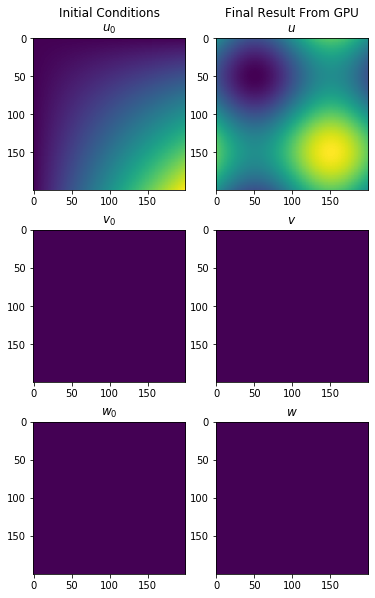

In [31]:
kernel_string = get_kernel_string_FK_model(**kwargs, DT=0.025)
iterations = 10**5

#setup thread block dimensions and compile the kernel
mod = SourceModule(block_size_string+kernel_string)
time_step_kernel = mod.get_function("time_step_kernel")

#create events for measuring performance
start = drv.Event()
end = drv.Event()

#move the data to the GPU
drv.memcpy_htod(u_old, u_initial)
drv.memcpy_htod(u_new, u_initial)
drv.memcpy_htod(v_old, v_initial)
drv.memcpy_htod(v_new, v_initial)
drv.memcpy_htod(w_old, w_initial)
drv.memcpy_htod(w_new, w_initial)

#call the GPU kernel 2*iterations times and measure performance
context.synchronize()
start.record()
for i in range(iterations):
    time_step_kernel(u_new, u_old, v_new, v_old, w_new, w_old, block=threads, grid=grid)
    time_step_kernel(u_old, u_new, v_old, v_new, w_old, w_new, block=threads, grid=grid)
end.record()
context.synchronize()
runtime = end.time_since(start)
print(f"{iterations*2} time steps took {runtime:.0f} ms.")

#copy the result from the GPU to Python for plotting
gpu_result_u = np.zeros_like(u_initial)
drv.memcpy_dtoh(gpu_result_u, u_new)
gpu_result_v = np.zeros_like(v_initial)
drv.memcpy_dtoh(gpu_result_v, v_new)
gpu_result_w = np.zeros_like(w_initial)
drv.memcpy_dtoh(gpu_result_w, w_new)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(6,10))
ax1.imshow(u_initial)
ax1.set_title("Initial Conditions\n$u_0$")
ax2.imshow(gpu_result_u)
ax2.set_title("Final Result From GPU\n$u$")

ax3.imshow(v_initial)
ax3.set_title("$v_0$")
ax4.imshow(gpu_result_v)
ax4.set_title("$v$")

ax5.imshow(w_initial)
ax5.set_title("$w_0$")
ax6.imshow(gpu_result_w)
ax6.set_title("$w$")
plt.show()

so, naively using np.float64 instead of np.float32 gave the wrong results!

In [26]:
print((gpu_result_u.dtype,gpu_result_v.dtype,gpu_result_w.dtype))

#verify that changes are happening in the auxiliary scalar fields
msd_u = sum(gpu_result_u.flatten()**2)
msd_v = sum(gpu_result_v.flatten()**2)
msd_w = sum(gpu_result_w.flatten()**2)
print((msd_u,msd_v,msd_w))

time_final = iterations*2*0.025 #milliseconds
print(f'{time_final/10**3:.1f} seconds of simulation time simulated in {runtime/10**3:.1f} seconds of real time on the right sized grid!')

(dtype('float64'), dtype('float64'), dtype('float64'))
(4.0820480049152e+17, 1.0362887398093386, 1.2197722687149621)
5.0 seconds of simulation time simulated in 22.3 seconds of real time on the right sized grid!


In [20]:
print((gpu_result_u.dtype,gpu_result_v.dtype,gpu_result_w.dtype))

#verify that changes are happening in the auxiliary scalar fields
msd_u = sum(gpu_result_u.flatten()**2)
msd_v = sum(gpu_result_v.flatten()**2)
msd_w = sum(gpu_result_w.flatten()**2)
print((msd_u,msd_v,msd_w))

time_final = iterations*2*0.025 #milliseconds
print(f'{time_final/10**3:.1f} seconds of simulation time simulated in {runtime/10**3:.1f} seconds of real time on the right sized grid!')

(dtype('float32'), dtype('float32'), dtype('float32'))
(2.6732465436858778e+17, 0.0, 2.9112931683450416e-10)
5.0 seconds of simulation time simulated in 14.4 seconds of real time on the right sized grid!


# TODO: dev for time_step_kernel
- TODO: put it all together test the numerical disagreement in the computational checks folder.  Write this up and report to WJ! He's gonna be so stoked!
- TODO: the following extra stuff
- TODO: tune the kernel for a slightly improved runtime!
- TODO (bonus) : make a copy method that shades according to an input I_ext field, that is user defined (with a pycuda gpuaray?).  
- TODO (bonus) : Making a flashy .mov of a heart shaped stimulus would impress WJ... I would need to dev some regular .png saving methods first.  perhaps this could be done in the device namespace thanks to my 2TB nvme ssd...
- TODO: try if the function_prepared call reduces runtime

In [32]:
type(u_initial)

numpy.ndarray

In [33]:
u_initial.dtype

dtype('float32')

In [35]:
u_initial.shape

(200, 200)

# DONE: simplest functional routine that uses time_step_kernel to generate a tip log file from a given initial condition

In [29]:
#initialize
import numpy as np, pandas as pd, matplotlib.pyplot as plt

#automate the boring stuff
# from IPython import utils
import time, os, sys, re
beep = lambda x: os.system("echo -n '\\a';sleep 0.2;" * x)
if not 'nb_dir' in globals():
	nb_dir = os.getcwd()
    
#LLVM JIT Acceleration
from numba import njit

from skimage import measure

#load the libraries
from lib import *
from lib.utils.dist_func import *

from lib.utils.utils_jsonio import *
#load parameters for parameter set 8 for the Fenton-Karma Model
param_file_name = '/home/timothytyree/Documents/GitHub/care/notebooks/lib/model/param_set_8.json'
kwargs = read_parameters_from_json(param_file_name)

from lib.model.minimal_model_cuda import *
#get the time_step_kernel
dt = 0.025
# kernel_string = get_kernel_string_FK_model(**kwargs, DT=dt)

from lib.measure.utils_measure_tips_cpu import fetch_txt_to_tip_dict
from lib.utils.ProgressBar import printProgressBar

#load the libraries
from lib.utils.operari import *
# from lib.measure.get_tips import *
# from lib.measure.intersection import *
# from lib.measure.tracking import link

#automate the boring stuff
# from IPython import utils
import time, os, sys, re
beep = lambda x: os.system("echo -n '\\a';sleep 0.2;" * x)
if not 'nb_dir' in globals():
    nb_dir = os.getcwd()
    
%autocall 1
%load_ext autoreload
%autoreload 2

Automatic calling is: Smart
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
#load initial conditions interactively
#find file interactively
# print("please select a file from within the desired folder.")
# input_file_name = search_for_file()
input_file_name='/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-2/ic-in/ic_200x200.001.32.npz'

In [31]:
ic = load_buffer(input_file_name)
height, width, channel_no = ic.shape

#map initial condition to the three initial scalar fields
u_initial = np.array(ic.astype(np.float64)[...,0])
v_initial = np.array(ic.astype(np.float64)[...,1])
w_initial = np.array(ic.astype(np.float64)[...,2])

In [33]:
dt = 0.025
kernel_string = get_kernel_string_FK_model(**kwargs, DT=dt,DX=0.025,height=height,width=width)

#initializing cuda context
#initialize PyCuda and get compute capability needed for compilation
context = drv.Device(0).make_context()
devprops = { str(k): v for (k, v) in context.get_device().get_attributes().items() }
cc = str(devprops['COMPUTE_CAPABILITY_MAJOR']) + str(devprops['COMPUTE_CAPABILITY_MINOR'])

#define how resources are used
# width  = kwargs['width']
# height = kwargs['height']
threads = (10,10,1)
grid = (int(width/10), int(height/10), 1)
block_size_string = "#define block_size_x 10\n#define block_size_y 10\n"

#don't allocate memory many times for the same task!
#allocate GPU memory for voltage scalar field
u_old = drv.mem_alloc(u_initial.nbytes)
u_new = drv.mem_alloc(u_initial.nbytes)

#allocate GPU memory for v and w auxiliary fields
v_old = drv.mem_alloc(v_initial.nbytes)
v_new = drv.mem_alloc(v_initial.nbytes)
w_old = drv.mem_alloc(w_initial.nbytes)
w_new = drv.mem_alloc(w_initial.nbytes)

#setup thread block dimensions and compile the kernel
mod = SourceModule(block_size_string+kernel_string)
time_step_kernel = mod.get_function("time_step_kernel")


In [49]:
#default observation parameters
n = 50  #half the number of steps between observations of spiral tips
nsteps = 10**6
pad = 10
edge_tolerance = 6
atol = 1e-10
printing=True

width, height, channel_no = ic.shape
zero_txt = np.zeros((width, height, channel_no), dtype=np.float64)
nanstate = [np.nan,np.nan,np.nan]
ycoord_mesh, xcoord_mesh = np.meshgrid(np.arange(0,width+2*(pad)),np.arange(0,width+2*pad))

In [50]:
def step_forward_2n_times(time_step_kernel,drv,n,txt_in,
                         u_new, u_old, v_new, v_old, w_new, w_old,
                         threads, grid):
    '''compute the time step for the correct number of iterations = steps/2'''
    iterations = n

    #map input condition to the three input scalar fields
    u_in = np.array(txt_in.astype(np.float64)[...,0])
    v_in = np.array(txt_in.astype(np.float64)[...,1])
    w_in = np.array(txt_in.astype(np.float64)[...,2])

    # #create events for measuring performance
    # start = drv.Event()
    # end = drv.Event()

    #move the data to the GPU
    drv.memcpy_htod(u_old, u_in)
    drv.memcpy_htod(u_new, u_in)
    drv.memcpy_htod(v_old, v_in)
    drv.memcpy_htod(v_new, v_in)
    drv.memcpy_htod(w_old, w_in)
    drv.memcpy_htod(w_new, w_in)

    #call the GPU kernel 2*iterations times (and don't measure performance)
    context.synchronize()
    # start.record()
    for i in range(iterations):
        time_step_kernel(u_new, u_old, v_new, v_old, w_new, w_old, block=threads, grid=grid)
        time_step_kernel(u_old, u_new, v_old, v_new, w_old, w_new, block=threads, grid=grid)
    # end.record()
    context.synchronize()
    # runtime = end.time_since(start)
    # print(f"{iterations*2} time steps took {runtime:.0f} ms.")

    #copy the result from the GPU to Python
    gpu_result_u = np.zeros_like(u_in)
    drv.memcpy_dtoh(gpu_result_u, u_old)
    gpu_result_v = np.zeros_like(v_in)
    drv.memcpy_dtoh(gpu_result_v, v_old)
    gpu_result_w = np.zeros_like(w_in)
    drv.memcpy_dtoh(gpu_result_w, w_old)
    txt_out_gpu = np.stack((gpu_result_u,gpu_result_v,gpu_result_w),axis=2)
    return txt_out_gpu

In [86]:
#initialize simulation
txt = ic.copy()
tme = 0.
tip_state_lst = []
nsteps=1000

In [87]:
txt_to_tip_dict=fetch_txt_to_tip_dict(width,height,DX=0.025,DY=0.025, **kwargs)

In [88]:
def get_one_step_map(time_step_kernel,drv,n,
                             u_new, u_old, v_new, v_old, w_new, w_old,
                             threads, grid):
    def one_step_map(txt):
        return step_forward_2n_times(time_step_kernel,drv,n,txt,
                             u_new, u_old, v_new, v_old, w_new, w_old,
                             threads, grid)
    return one_step_map


In [92]:
#integrate forward in time
one_step_map=get_one_step_map(time_step_kernel,drv,n,
                             u_new, u_old, v_new, v_old, w_new, w_old,
                             threads, grid)
tmax = 200#nsteps*dt
while tme <= tmax:
    #step forward 2n times
    txt_in = txt.copy()
#     txt = step_forward_2n_times(time_step_kernel,drv,n,txt_in,
#                              u_new, u_old, v_new, v_old, w_new, w_old,
#                              threads, grid)
    txt=one_step_map(txt)
    tme += 2*n*dt

#     dict_out = txt_to_tip_dict(txt, nanstate, zero_txt, xcoord_mesh, ycoord_mesh, 
#                         pad=pad, edge_tolerance=edge_tolerance, atol=atol,tme=tme)
#     tip_state_lst.append(dict_out)
#     num_tips = dict_out['n']
#     stop_early = (num_tips==0) & (tme>100)
#     if stop_early:
#         break
    if printing:
        printProgressBar(tme, tmax, prefix = 'Progress:', suffix = 'Complete', length = 50)

In [90]:
base_dir = '/'.join(os.path.dirname(input_file_name).split('/')[:-1])
base_save_folder_name = 'ds_5_param_set_8'
base_save_dir = os.path.join(base_dir, base_save_folder_name)

#define subfolders
subfolder_list = ('birth-death-rates', 'trajectories', 'Log')
data_folder_bdrates = os.path.join(base_save_dir,subfolder_list[0])
data_folder_traj    = os.path.join(base_save_dir,subfolder_list[1])
data_folder_log     = os.path.join(base_save_dir,subfolder_list[2])

data_fn_log = os.path.basename(input_file_name).replace('.npz', '_log.csv')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


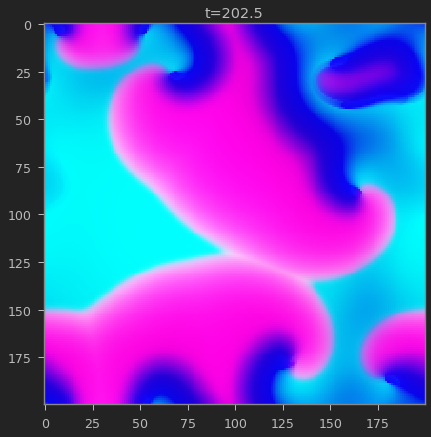

In [93]:
plt.imshow(txt)
plt.title(f"t={tme}")
plt.show()

In [69]:
data_fn_log

'ic_200x200.005.21_log.csv'

In [70]:
#save tip log.csv in the appropriate folder
df = pd.DataFrame(tip_state_lst)
df.to_csv(data_fn_log, index=False)

In [71]:
#move the completed file to ic-out
completed_ic_fn = input_file_name.replace('ic-in','ic-out')
# os.rename(input_file_name,completed_fn)

In [73]:
# input_file_name = '/home/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-2/ic-in/ic_200x200.005.21.npz'

# from lib.tip_log_from_ic import *
# %autocall 1
# %load_ext autoreload
# %autoreload 2

# generate_tip_log_from_ic(input_file_name, nsteps=10**3)

# # 10**4/10**2*2/60
# np.max(txt[...,0])

In [61]:
tme

12.5